In [303]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
! pip install cvxpy
import cvxpy as cp
from tqdm import tqdm

iris = load_iris()

In [304]:
def gaussian_ker(x, y, q):
    """a function to compute the gaussian kernel of two points
    -------------------------------
    inputs : 

    x : array-like, vector
    first vector for which we want to compute the kernel

    y : array-like, vector
    second vector for which we want to compute the kernel

    q : positive float,
    value of the bandwidth of the kernel

    returns:
    ker : float,
    the value of the kernel
    -------------------------------
    """

    ker = np.exp(-q * np.linalg.norm(x - y) ** 2)
    return ker

In [305]:
def gram_mat(X, q):
    """
    a function to compute the gram matrix of a given dataset

    ----------------------------------------
    inputs : 
    X : array-like object, must be 2D
    the data for which we want to compute the gram matrix

    q : positive float, 
    the bandwidth of the gaussian kernel
    -----------------------------------------

    returns:
    K : the gram matrix
    """
    
    norms = np.linalg.norm(X, axis=1)**2
    dot = X@X.T
    squared_euclidian_distances = norms[:, None] - 2 * dot + norms[None, :]
    K = np.exp(-squared_euclidian_distances*q)
    return K

In [306]:
def compute_seg(x, y, nb=20):
    """
    a function used to compute the segment between two points
    -----------------------------------
    Parameters : 

    x : array-like obj,
    an input, d>=2

    y : array-like obj, 
    the second input

    nb : int, 
    the number of points we want to have between the two points

    Returns : 

    segment : array-like
    an array of shape d (dimension of x), nb
    ---------------------------------------
    """
    d = x.shape[0]
    segment = np.zeros((nb, d))
    points = np.linspace(start=0., stop=1., num=nb, endpoint=True)
    
    for i in range(nb):
        t = points[i]
        segment[i, :] = (1-t) * x + t * y
        
    return segment

In [307]:
def radius(x, sample, beta, bkb, q, ker_self=1.):
    """
    compute the radius for a given instance x
    -----------------------------------------------
    Parameters : 

    x : 1-D vector,
    the input vector

    sample : matrix, 
    the whole sample, 

    beta : array-like, 
    the calculated beta

    bkb : float,
    the result of beta.T@K@beta

    ker_self : float,
    the value of the kernel of the selected instance with itself, 
    set to 1 by default as we use mostly the gaussian kernel

    returns :

    radius : float,
    the distance between the test instance and the center of the 
    sphere enclosing all the points in the Hilbert space
    -----------------------------------------------
    """
    nb_samp = sample.shape[0]
    temp_k = np.zeros(nb_samp)

    for elem in range(nb_samp):
        temp_k[elem] = gaussian_ker(x, sample[elem], q=q)
        
    return np.sqrt(ker_self - 2 * np.dot(temp_k, beta) + bkb)

Application on the Iris dataset

In [308]:
data = iris.data
target = iris.target

In [309]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prétraitement : Normaliser les données (centrage et réduction)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Initialisation de la PCA
n_components = 2  # Choisissez le nombre de composantes principales souhaitées
pca = PCA(n_components=n_components)

# Appliquer la PCA
principal_components = pca.fit_transform(data_scaled)

# Créer un DataFrame des composantes principales
columns = [f"PC{i+1}" for i in range(n_components)]
principal_df = pd.DataFrame(data=principal_components, columns=columns)

# Variance expliquée par chaque composante
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

# Somme de la variance expliquée
print("Variance totale expliquée :", np.sum(pca.explained_variance_ratio_))

Variance expliquée par chaque composante : [0.72962445 0.22850762]
Variance totale expliquée : 0.9581320720000164


In [310]:
def find_max(data):
    n = data.shape[0]
    max_norm = 0
    for i in range(n):
        for j in range(i+1, n):
            norm = np.linalg.norm(data[i] - data[j]) ** 2
            if norm > max_norm:
                max_norm = norm
    return max_norm

In [311]:
# Hyperparameters of the SVC procedure
N = len(principal_df)
q = 2
p = 0.4
C = 1 / (N * p)
# C = 1

In [312]:
gram_x = gram_mat(X=principal_df, q=q)

In [313]:
n = len(principal_df)
beta = cp.Variable(n)
gram_x += gram_x.T
gram_x /= 2
gram_x = cp.psd_wrap(gram_x)


# Formulation de l'objectif
objective = cp.Maximize(cp.sum(np.ones(n) @ beta) - cp.quad_form(beta, gram_x))

# Contraintes
constraints = [
    beta >= 0,  # 0 <= beta_j
    beta <= C,  # beta_j <= C
    cp.sum(beta) == 1  # La somme des éléments de beta doit être égale à 1
]

# Définir le problème d'optimisation
problem = cp.Problem(objective, constraints)

# Résoudre le problème
problem.solve()

np.float64(0.9287795111114973)

In [314]:
true_beta = beta.value
beta_k_beta = true_beta.T @ gram_x @ true_beta

In [315]:
index_of_sv = []
index_of_bsv = []

for i in range(N):
    if 1e-10 < true_beta[i] < C - 1e-3:
        index_of_sv.append(i)
    elif true_beta[i] >= C - 1e-3:
        index_of_bsv.append(i)

print('index of sv', index_of_sv)
print('number of sv', len(index_of_sv))
print('index of bsv', index_of_bsv)
print('number of bsv', len(index_of_bsv))

index of sv [0, 4, 10, 17, 19, 21, 27, 36, 43, 44, 48, 50, 52, 54, 55, 58, 61, 63, 65, 67, 69, 70, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 86, 87, 89, 90, 91, 92, 94, 97, 99, 100, 102, 104, 106, 107, 110, 112, 115, 116, 120, 124, 127, 129, 133, 137, 138, 139, 140, 141, 143, 145, 147]
number of sv 64
index of bsv [5, 6, 8, 13, 14, 15, 18, 20, 22, 23, 25, 31, 32, 33, 37, 38, 41, 42, 45, 46, 51, 53, 56, 57, 59, 60, 62, 64, 68, 79, 85, 88, 93, 95, 98, 105, 108, 109, 113, 117, 118, 119, 121, 122, 125, 128, 130, 131, 132, 135, 136, 144, 146, 148, 149]
number of bsv 55


In [316]:
potential_sv = principal_df.iloc[index_of_sv, :].to_numpy()

In [317]:
gram_x = gram_mat(X=principal_df, q=q)
gram_x += gram_x.T
gram_x /= 2
r = []
beta_k_beta = true_beta.T @ gram_x @ true_beta
for point_sv in potential_sv:
    temp_K = np.zeros(n)
    for elem in range(n):
        temp_K[elem] = gaussian_ker(point_sv, principal_df.iloc[elem, :], q=q)
    r_xi = np.sqrt(1 - 2 * np.dot(temp_K, true_beta) + beta_k_beta)
    r.append(r_xi)
rad = np.mean(r)

In [318]:
adjacency_mat = np.zeros((n, n))

for i in tqdm(range(n)):
    for j in range(i+1, n):
        decision = True
        segment = compute_seg(x=principal_df.to_numpy()[i,:], y=principal_df.to_numpy()[j,:])
        list_of_val = []
        for point in segment:
            dist = radius(x=point, beta=true_beta, bkb=beta_k_beta, sample=principal_df.to_numpy(), q=q)
            list_of_val.append(dist)
        for value in list_of_val:
            if value > rad:
                decision = False
        
        if decision == True:
            adjacency_mat[i, j] = 1

adjacency_mat = adjacency_mat + adjacency_mat.T
adjacency_mat /= 2
for i in range(n):
    adjacency_mat[i,i] = 0

100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


In [319]:
import networkx as nx
G = nx.from_numpy_array(adjacency_mat)

clusters = list(nx.connected_components(G))
print('number of clusters detected', len(clusters))

number of clusters detected 113


In [320]:
# Trier les clusters par taille décroissante
sorted_clusters = sorted(clusters, key=len, reverse=True)

# Afficher la taille du plus gros cluster
print(f"Taille du plus gros cluster: {len(sorted_clusters[0])}")

# Si vous voulez afficher les tailles des 5 plus gros clusters, par exemple :
top_5_clusters = sorted_clusters[:5]
for i, cluster in enumerate(top_5_clusters, start=1):
    print(f"Taille du cluster {i}: {len(cluster)}")


Taille du plus gros cluster: 22
Taille du cluster 1: 22
Taille du cluster 2: 13
Taille du cluster 3: 4
Taille du cluster 4: 2
Taille du cluster 5: 1


In [321]:
from collections import Counter
misclassified_count = 0

# Parcourir chaque cluster
for cluster in clusters:

    if len(cluster) > 1:
        # Extraire les labels des points dans le cluster
        cluster_labels = [target[i] for i in cluster]
        
        # Trouver le label majoritaire dans le cluster
        majority_label = Counter(cluster_labels).most_common(1)[0][0]
        
        # Compter les misclassifications dans ce cluster
        for i in cluster:
            if target[i] != majority_label:
                misclassified_count += 1

print(f"Nombre total de misclassifications : {misclassified_count}")


Nombre total de misclassifications : 3


In [322]:
def radius_plot(x1, x2):
    x = np.array([x1, x2])
    return radius(x, sample=principal_df.to_numpy(), beta=true_beta, bkb=beta_k_beta, q=q)

In [323]:
# Créer une grille de points dans le plan
x1 = np.linspace(-4, 4, 100)  # Plage pour x1
x2 = np.linspace(-2, 2, 100)  # Plage pour x2
X1, X2 = np.meshgrid(x1, x2)  # Créer la grille 2D

# Évaluer la fonction sur la grille
Z = np.zeros(X1.shape)

# Calculer Z pour chaque combinaison de X1 et X2
for i in range(X1.shape[0]):  # Itérer sur les lignes
    for j in range(X1.shape[1]):  # Itérer sur les colonnes
        Z[i, j] = radius_plot(X1[i, j], X2[i, j])

/tmp/ipykernel_89396/1959050169.py:1: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(X1, X2, Z, levels=[np.mean(r)], cmap='viridis', color='green', linewidths=0.5)


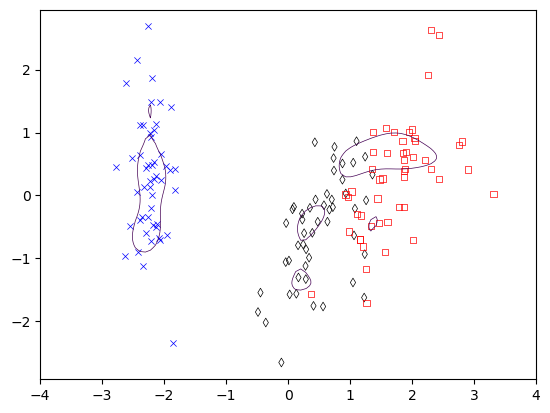

In [324]:
plt.contour(X1, X2, Z, levels=[np.mean(r)], cmap='viridis', color='green', linewidths=0.5)
plt.scatter(principal_df.iloc[:50, 0],  principal_df.iloc[:50, 1], marker='x', color='blue', s=20, linewidths=0.5)
plt.scatter(principal_df.iloc[50:100, 0],  principal_df.iloc[50:100, 1], marker='d', color='black', facecolors="none", s=20, linewidths=0.5)
plt.scatter(principal_df.iloc[100:, 0],  principal_df.iloc[100:, 1], marker='s', color='red', facecolors="none", s=20, linewidths=0.5)
plt.show()